In [313]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import SGDRegressor
import seaborn as sns
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import Lasso
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer, TransformedTargetRegressor
from sklearn.impute import SimpleImputer
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.feature_selection import SelectFromModel
from sklearn.feature_extraction.text import CountVectorizer


plt.rcParams['figure.figsize'] = (25,5)

# Assignment 2 - Regression
### Predict the TOTAL COMPENSATION for this year. 

The data file provided is a salary survey for tech workers in Europe. We want to predict the total amount of compensation they bring in each year, based off of the details of their work. 

Some notes that will be important:
<ul>
    <li>The total compensation will need to be constructed, there is a column for salary, "Yearly brutto salary (without bonus and stocks) in EUR", as well as a column for bonus compensation, "Yearly bonus + stocks in EUR". 
    <li>Some categorical variables will need some work, and there isn't generally an exact answer. The main concern is things with categories that have a bunch of values with a very small count. For example, if there is only 1 person in City X, then that value likely needs to be addressed. We don't want it encoded into a new column of one 1 and thousands of 0s. 
    <li>There is an article exploring some of the data here: https://www.asdcode.de/2021/01/it-salary-survey-december-2020.html
    <li>Imputation and a bit of data manipulation will be required. 
    <li>Use any regression method you'd like. Some ones are closely related to what we've done, you may want to look at them, e.g. ExtraTreesRegressor. 
    <li>Initial accurracy, and potentially final accuracy, may not be great. When I made a plain model will little optimization the errors were large and the R2 was low. There is lots of room for optimization. 
    <li>Research challenge - try some work on the target, look into TransformedTargetRegressor and see if that helps. Recall in stats when we had skewed distributions... Maybe it helps, maybe it doesn't. 
    <li>EDA and data prep are up to you - you'll probably need to do a little exploring to figure out what cleanup is needed. When I did it, I did things kind of iteratively when I did it. For example, look at the value counts, figure out how to treat the different categories, clean something up, look at the results, potentially repeat if needed. After you figure out what needs to be done, you may be able to take some of those steps and incorporate them into a pipeline to be cleaner....
    <li><b>CRITICAL - Please make sure your code runs with RUN ALL. It should load the data that you're given, do all the processing, and spit out results. Comment out or remove anything that you've cleaned up and don't need - e.g. if you scaled a value manually, then moved that into a pipeline, don't leave the original scaling code active when the file is run.</b>
</ul>

### Details and Deliverables

You'll need to build code to produce the predictions. In particular, there's a few things that'll be marked:
<ul>
    <li>Please add a markdown cell at the bottom, and put in a few notes addressing the following:
    <ul>
        <li> Accuracy of your models with/without feature selection. Include both train/test for each. Please use R2 and RMSE. 
        <li> Feature Selection - Please identify what you did for feature selection. No need for a long explaination, something along the lines of "I did X, and the result was that 4 features were removed". Try at least 2 things. 
        <li> Hyperparameter Changes / Grid Search Improvements. What did you try, and why. Similar explaination to above, short. 
        <li> Overall this section should be roughly as long as this intro block - just outline what the results were, what you did to improve, and the results after. 
        <li> If you could use titles/bullet points I'd really appreciate it. 
    </ul>
    <li>Grade Breakdown:
    <ul>
        <li> Code is readable, there are comments: 20%
        <li> Explaination as defined above: 60% (20% each point)
        <li> Accuracy: 20% As compared to everyone else. This will be generously graded, I won't be surprised if overall accuracy is low for most people. 
    </ul>
</ul>

In [314]:
#Load Data
df = pd.read_csv("data/Euro_Salary.csv")
df.describe(include="all").T

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
Timestamp,1253,1248,24/11/2020 13:55:19,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Age,1226.0,NaN,NaN,NaN,32.509788,5.663804,20.0,29.0,32.0,35.0,69.0
Gender,1243,3,Male,1049,NaN,NaN,NaN,NaN,NaN,NaN,NaN
City,1253,119,Berlin,681,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Position,1247,148,Software Engineer,387,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Total years of experience,1237,48,10,138,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Years of experience in Germany,1221,53,2,195,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Seniority level,1241,24,Senior,565,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Your main technology / programming language,1126,256,Java,184,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Other technologies/programming languages you use often,1096,562,Javascript / Typescript,44,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [315]:
df.head()

,Timestamp,Age,Gender,City,Position,Total years of experience,Years of experience in Germany,Seniority level,Your main technology / programming language,Other technologies/programming languages you use often,Yearly brutto salary (without bonus and stocks) in EUR,Yearly bonus + stocks in EUR,Number of vacation days,Employment status,Сontract duration,Main language at work,Company size,Company type
0,24/11/2020 11:14:15,26.0,Male,Munich,Software Engineer,5,3,Senior,TypeScript,"Kotlin, Javascript / Typescript",80000.0,5000,30,Full-time employee,Unlimited contract,English,51-100,Product
1,24/11/2020 11:14:16,26.0,Male,Berlin,Backend Developer,7,4,Senior,Ruby,NaN,80000.0,NaN,28,Full-time employee,Unlimited contract,English,101-1000,Product
2,24/11/2020 11:14:21,29.0,Male,Berlin,Software Engineer,12,6,Lead,Javascript / Typescript,"Javascript / Typescript, Docker",120000.0,120000,30,Self-employed (freelancer),Temporary contract,English,101-1000,Product
3,24/11/2020 11:15:24,28.0,Male,Berlin,Frontend Developer,4,1,Junior,Javascript,NaN,54000.0,NaN,24,Full-time employee,Unlimited contract,English,51-100,Startup
4,24/11/2020 11:15:46,37.0,Male,Berlin,Backend Developer,17,6,Senior,C# .NET,".NET, SQL, AWS, Docker",62000.0,NaN,29,Full-time employee,Unlimited contract,English,101-1000,Product


In [316]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1253 entries, 0 to 1252
Data columns (total 18 columns):
 #   Column                                                  Non-Null Count  Dtype  
---  ------                                                  --------------  -----  
 0   Timestamp                                               1253 non-null   object 
 1   Age                                                     1226 non-null   float64
 2   Gender                                                  1243 non-null   object 
 3   City                                                    1253 non-null   object 
 4   Position                                                1247 non-null   object 
 5   Total years of experience                               1237 non-null   object 
 6   Years of experience in Germany                          1221 non-null   object 
 7   Seniority level                                         1241 non-null   object 
 8   Your main technology / programming lan

### Construct Target ###

In [317]:
# Rename some columns to shorter more convenient labels
df.rename({'Yearly bonus + stocks in EUR': 'Bonus', 'Yearly brutto salary (without bonus and stocks) in EUR': 'Salary'}, axis=1, inplace=True)

In [318]:
df['Bonus'].value_counts().sort_index(ascending=False).head(20)

depends     1
bvg only    1
Not sure    1
Na          1
99000       2
97000       1
96000       1
95000       4
9450        1
9400        1
92000       1
90000       4
9000        4
89000       1
88000       1
87250       1
86000       1
85000       3
8500        1
84000       1
Name: Bonus, dtype: int64

In [319]:
# Convert string and NaN in bonus columns to zero
df['Bonus'] = pd.to_numeric(df['Bonus'], errors='coerce')
df['Bonus'] = df['Bonus'].fillna(0)

In [320]:
# Target will be Bonus and Salary
df['Target'] = df['Bonus'] + df['Salary']
df['Target'] = df['Target'].fillna(df['Target'].median())

In [321]:
# Incomes over 300000 EUR will be considered outliers
print('Before outliers removed:', df.shape)
df = df[df['Target'] < 300000]
df = df.reset_index()
print('After outliers removed:', df.shape)

Before outliers removed: (1253, 19)
After outliers removed: (1240, 20)


<AxesSubplot:xlabel='Target', ylabel='Count'>

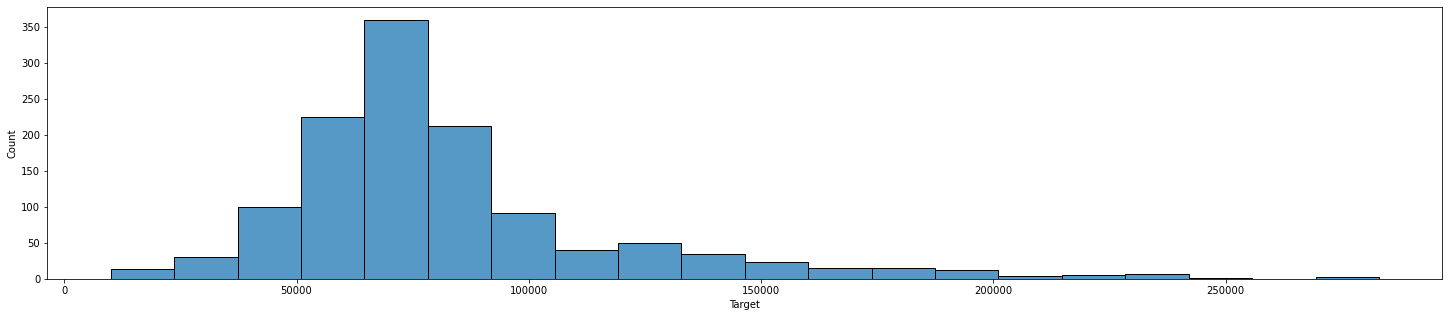

In [322]:
sns.histplot(df['Target'], bins=20)

### Explore the Features ###

Most likely will group less common values together as 'Other' since they are not representative of a larger sample. Will iterate through value_counts() and sort through values to determine how clean the data. Value_counts and sort_values, etc will not be shown every time to save space.

In [323]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1240 entries, 0 to 1239
Data columns (total 20 columns):
 #   Column                                                  Non-Null Count  Dtype  
---  ------                                                  --------------  -----  
 0   index                                                   1240 non-null   int64  
 1   Timestamp                                               1240 non-null   object 
 2   Age                                                     1215 non-null   float64
 3   Gender                                                  1231 non-null   object 
 4   City                                                    1240 non-null   object 
 5   Position                                                1235 non-null   object 
 6   Total years of experience                               1225 non-null   object 
 7   Years of experience in Germany                          1210 non-null   object 
 8   Seniority level                       

In [324]:
# Function to replace values that don't appear very often
# From Akeem's sample_exploration
def replace_low_freq(d, col, threshold=10, replacement='other'):
    value_counts = d[col].value_counts() 
    to_remove = value_counts[value_counts <= threshold].index
    tmp = d[col].replace(to_replace=to_remove, value=replacement)
    return tmp

#### Timestamp ####

In [325]:
df['Timestamp']

0       24/11/2020 11:14:15
1       24/11/2020 11:14:16
2       24/11/2020 11:14:21
3       24/11/2020 11:15:24
4       24/11/2020 11:15:46
               ...         
1235    18/01/2021 15:05:50
1236    18/01/2021 17:46:02
1237    18/01/2021 23:20:35
1238    19/01/2021 10:17:58
1239    19/01/2021 12:01:11
Name: Timestamp, Length: 1240, dtype: object

Timestamp doesn't look super useful. Values seem to be within a year or two. Seems like values for when the data was entered.

In [326]:
# Drop Timestamp column
df = df.drop(columns=['Timestamp'])

#### Gender ####

From value counts, majority are Male or Female, some are Diverse or NaN. Since Diverse and NaN are few we will group them into Other.

In [327]:
df['Gender'] = df['Gender'].fillna('Other Gender')
df['Gender'] = df['Gender'].replace('Diverse', 'Other Gender')

#### City ####

From df.info, City doesn't seem to have nulls. We will try to group the less common cities together into 'Other Cities'.

In [328]:
df['City'].nunique()

118

In [329]:
df['City'] = replace_low_freq(df, 'City', 5, 'Other Cities') # Threshold of 5 or less in dataset

In [330]:
df['City'].nunique()

13

#### Position ####

In [331]:
df['Position '] = replace_low_freq(df, 'Position ', threshold=5, replacement='Other')

#### Total Years of Experience ####

In [332]:
df['Total years of experience'].value_counts(ascending=True).head(20)

5.5                                                    1
383                                                    1
6 (not as a data scientist, but as a lab scientist)    1
31                                                     1
15, thereof 8 as CTO                                   1
2,5                                                    1
1 (as QA Engineer) / 11 in total                       1
24                                                     1
29                                                     1
28                                                     1
7.5                                                    1
6.5                                                    1
26                                                     1
40                                                     1
less than year                                         1
27                                                     2
1,5                                                    2
23                             

At first glance, a lot (maybe not all) of non-numeric values could be reasonably represented by 0. Also, a lot of european countries use decimal commas. We can try to change the comma into a period.

In [333]:
def commaDecimal(value):
    text = str(value).strip()
    if ',' in text:
        text = text.replace(',', '.')
    try:
        num = float(text)
        if num > 50:
            return np.nan
    except ValueError:
        num = 0
    return num

In [334]:
df['Total years of experience'] = df['Total years of experience'].apply(commaDecimal)

In [335]:
df['Total years of experience'].max()

40.0

#### Years of Experience in Germany ####

In [336]:
df['Years of experience in Germany'].value_counts(ascending=True).head(50)

less than year                                           1
0.2                                                      1
4,5                                                      1
0.9                                                      1
25                                                       1
26                                                       1
< 1                                                      1
3 months                                                 1
4.5                                                      1
4 (in Switzerland), 0 (in Germany)                       1
0.8                                                      1
0.1                                                      1
2.6                                                      1
17                                                       1
3 (in Poland)                                            1
<1                                                       1
4 month                                                 

In [337]:
# Do same thing as with Years of Experience
df['Years of experience in Germany'] = df['Years of experience in Germany'].apply(commaDecimal)

#### Seniority Level ####

In [338]:
df['Seniority level'] = replace_low_freq(df, 'Seniority level', 5, 'Other')

#### Programming Languages ####

In [339]:
# Fill null values with empty string 
df[['Your main technology / programming language', 'Other technologies/programming languages you use often']] = df[['Your main technology / programming language', 'Other technologies/programming languages you use often']].fillna('')

In [340]:
# Combine Programming Languages into one column to be used in Count Vectorizer
df['ProgrammingLanguages'] = df['Your main technology / programming language'] + ' ' + df['Other technologies/programming languages you use often']

In [341]:
df['ProgrammingLanguages'].sort_values(ascending=False)

43      С# Python, C/C++, Javascript / Typescript, .NE...
762                                                 Офмф 
162     yaml Python, PHP, Javascript / Typescript, SQL...
1239    yaml Python, AWS, Kubernetes, Docker, terrafor...
534       typescript Javascript / Typescript, .NET, Azure
                              ...                        
429                                                      
425                                                      
281                                                      
93                                                       
705                                                      
Name: ProgrammingLanguages, Length: 1240, dtype: object

In [342]:
df = df.drop(columns= ['Your main technology / programming language', 'Other technologies/programming languages you use often'])

#### Vacation Days ####

In [343]:
df['Number of vacation days'].value_counts(ascending=True)

10                                                1
30 in contract (but theoretically unlimited)      1
Unlimited                                         1
16                                                1
3                                                 1
365                                               1
~25                                               1
34                                                1
50                                                1
38                                                1
60                                                1
24 labour days                                    1
37.5                                              1
1                                                 1
5                                                 1
37                                                1
39                                                1
23+                                               1
(no idea)                                         1
Unlimited   

In [344]:
# Convert unlimited vacation to 100
# Extract numbers from string and concatenate them together
# Return float if valid number, else return NaN
def vacayNum(value):
    text = str(value).strip().lower()
    try:
        num = float(value)
        return num
    except ValueError:
        if text == 'unlimited':
            num = 100
        else:
            num = ''
            for i in text:
                if i in '123456890':
                    num+=i
    if num == '':
        return np.nan
    else:
        return float(num)

In [345]:
df['Number of vacation days'] = df['Number of vacation days'].apply(vacayNum)

#### Main Langauge at Work ####

In [346]:
df['Main language at work'].value_counts()

English               1008
German                 186
Russian                 12
Italian                  3
Spanish                  3
English and German       2
Polish                   2
Русский                  2
Czech                    2
50/50                    1
Deuglisch                1
French                   1
both                     1
Russian, English         1
Name: Main language at work, dtype: int64

There are some people that have more than one main language at work. However, trying to deal with those values individually won't add a lot of value.

In [347]:
df['Main language at work'] = replace_low_freq(df, 'Main language at work', threshold=5, replacement='Other')

#### Employment Status ####

In [348]:
df['Employment status'].value_counts(dropna=False)

Full-time employee                                                                 1180
Self-employed (freelancer)                                                           26
NaN                                                                                  16
Part-time employee                                                                    8
Founder                                                                               3
Company Director                                                                      1
working student                                                                       1
Working Student                                                                       1
Full-time position, part-time position, & self-employed (freelancing, tutoring)       1
Intern                                                                                1
full-time, but 32 hours per week (it was my request, I'm a student)                   1
Werkstudent                     

In [349]:
df['Employment status'] = replace_low_freq(df, 'Employment status', threshold=2, replacement='Other Employment Status')

#### Contract Duration ####

In [350]:
df['Сontract duration'].value_counts()

Unlimited contract    1151
Temporary contract      63
Name: Сontract duration, dtype: int64

#### Company Type ####

In [351]:
df['Company type'].value_counts()

Product                754
Startup                248
Consulting / Agency    141
Bank                     5
Media                    3
                      ... 
Publisher                1
Energy                   1
Enterprise               1
service                  1
eCommerce                1
Name: Company type, Length: 63, dtype: int64

In [352]:
df['Company type'] = replace_low_freq(df, 'Company type', threshold=2, replacement='Other Company Type')

#### Last Data Cleanup Steps Before Model ####

In [353]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1240 entries, 0 to 1239
Data columns (total 18 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   index                           1240 non-null   int64  
 1   Age                             1215 non-null   float64
 2   Gender                          1240 non-null   object 
 3   City                            1240 non-null   object 
 4   Position                        1235 non-null   object 
 5   Total years of experience       1224 non-null   float64
 6   Years of experience in Germany  1210 non-null   float64
 7   Seniority level                 1229 non-null   object 
 8   Salary                          1240 non-null   float64
 9   Bonus                           1240 non-null   float64
 10  Number of vacation days         1174 non-null   float64
 11  Employment status               1224 non-null   object 
 12  Сontract duration               12

Impute missing values in categorical features. Numerical features handled by pipeline

In [354]:
# Categorical features impute with mode
for column in df.select_dtypes(exclude=np.number).columns.to_list():
    print(df[column].value_counts().idxmax())
    df[column] = df[column].fillna(df[column].value_counts().idxmax())

Male
Berlin
Software Engineer
Senior
Full-time employee
Unlimited contract
English
1000+
Product
 


In [355]:
# sns.pairplot(data=df)

Use CountVectorizer to One-hot encode programming languages

In [356]:
# CountVectorizer to do One-hot-ish encoding
# Token pattern also recognizes things like .NET and C++/C#/C, use top 50 'languages'
# Duplicates will be treated as 1 value
vec_cv = CountVectorizer(max_features=50, token_pattern=r"\.?\w+[+#]*", binary=True) 
tmp = vec_cv.fit_transform(df['ProgrammingLanguages'])
tok_cols = vec_cv.get_feature_names_out()
tok_df = pd.DataFrame(tmp.toarray(), columns=tok_cols)

print(tok_cols)
print("original:", df['ProgrammingLanguages'].shape)
print("vectorized:", tmp.shape)

df = pd.concat([df, tok_df], axis=1) # Add languages as columns to original dataframes

['.js' '.net' 'abap' 'android' 'angular' 'apache' 'aws' 'azure' 'bash' 'c'
 'c#' 'c++' 'clojure' 'cloud' 'docker' 'elixir' 'embedded' 'figma' 'gcp'
 'go' 'golang' 'google' 'groovy' 'ios' 'java' 'javascript' 'js' 'kotlin'
 'kubernetes' 'linux' 'node' 'nodejs' 'objective' 'on' 'perl' 'php'
 'python' 'pytorch' 'r' 'react' 'ruby' 'rust' 'sap' 'scala' 'sketch'
 'spark' 'sql' 'swift' 'terraform' 'typescript']
original: (1240,)
vectorized: (1240, 50)


In [357]:
# Drop redundant columns and columns included in target
df = df.drop(columns=['ProgrammingLanguages','Salary','Bonus'])

In [358]:
df.head()

,index,Age,Gender,City,Position,Total years of experience,Years of experience in Germany,Seniority level,Number of vacation days,Employment status,...,ruby,rust,sap,scala,sketch,spark,sql,swift,terraform,typescript
0,0,26.0,Male,Munich,Software Engineer,5.0,3.0,Senior,30.0,Full-time employee,...,0,0,0,0,0,0,0,0,0,1
1,1,26.0,Male,Berlin,Backend Developer,7.0,4.0,Senior,28.0,Full-time employee,...,1,0,0,0,0,0,0,0,0,0
2,2,29.0,Male,Berlin,Software Engineer,12.0,6.0,Lead,30.0,Self-employed (freelancer),...,0,0,0,0,0,0,0,0,0,1
3,3,28.0,Male,Berlin,Frontend Developer,4.0,1.0,Junior,24.0,Full-time employee,...,0,0,0,0,0,0,0,0,0,0
4,4,37.0,Male,Berlin,Backend Developer,17.0,6.0,Senior,29.0,Full-time employee,...,0,0,0,0,0,0,1,0,0,0


#### Create Model ####

In [359]:
# Train test split
y = df["Target"]
x = df.drop(columns={"Target"})
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3)

In [360]:
# Preprocessing steps

# For numeric features
numeric_features_ = df.select_dtypes(include=np.number).columns.to_list() # Select all columns with numeric data, includes programming languages
numeric_features_.remove('Target')
numeric_transformer_ = Pipeline( steps=[
        ("imputer", SimpleImputer(strategy="median")),
        ("scaler", MinMaxScaler())
    ])

# For categorical features
categorical_features_ = df.select_dtypes(exclude=np.number).columns.to_list() # Select all columns without numeric data
categorical_transformer_ = OneHotEncoder(handle_unknown='ignore')

# Combine into column transformer
preprocessor_ = ColumnTransformer( transformers=[
        ("num", numeric_transformer_, numeric_features_),
        ("cat", categorical_transformer_, categorical_features_)
    ])

In [361]:
# Random Forest for Regression Model
estimator = RandomForestRegressor(n_jobs=-1, random_state=0)

In [362]:
# See the difference in score between log transformed y-values and non-transformed y-values

# Transformed with Transformed Target Regressor model
tt = TransformedTargetRegressor(regressor=estimator, func=np.log, inverse_func=np.exp) # estimator is RandomForestRegressor
pipe_TT = Pipeline( steps = [
        ("pre", preprocessor_),
        ("TT_regressor", tt)
        ])

# Regular Random Forest Regression model without transforming y values
pipe_noTT = Pipeline( steps = [
        ("pre", preprocessor_),
        ("forest_noTT", estimator)
        ])

pipe_TT.fit(x_train,y_train)
pipe_noTT.fit(x_train, y_train)

print(pipe_TT.score(x_test, y_test))
print()
print(pipe_noTT.score(x_test, y_test))

0.23867736388190586

0.23584445574513702


Seems like a toss-up of which one is better. With the current iteration of train-test split, using Transformed Target Regressor is slightly worse. However, it will change if you run the code again. Overall, not a big difference and I have decided not to use it.

In [363]:
# For model with feature selection

# Lasso Feature Selection
sfm = SelectFromModel(Lasso(alpha=125))

# Combine preprocessing, selector and estimator
pipe = Pipeline( steps = [
        ("pre", preprocessor_),
        ('selector', sfm),
        ("forest", estimator)
        ])

# Grid for GridSearch in model with features selection
params_ = {
        "forest__min_samples_leaf": [i for i in range(2, 6)], 
        "forest__n_estimators": [300, 400],
        "forest__max_features": [.1, .25, .50],
        "forest__ccp_alpha": [0, 0.0001, 0.0002],
        # "selector__estimator__alpha":[75, 100, 125, 150] # comment out to run faster, using value 125 
        }
# GridSearch with pipe as estimator
f1 = GridSearchCV(pipe, param_grid=params_, cv=5, n_jobs=-1) 
f1.fit(x_train, y_train) # Fit model

# Final model with feature selection
model_FS = f1.best_estimator_ 
preds_FS = model_FS.predict(x_test)

In [364]:
# For model with 'no feature selection' 

# Combine preprocessing and estimator
pipe2 = Pipeline( steps = [
        ("pre", preprocessor_),
        ("forest", estimator)
        ])

# Grid for GridSearch in model without feature selection
params_2 = {
        "forest__min_samples_leaf": [i for i in range(2, 6)], 
        "forest__n_estimators": [300, 400],
        "forest__bootstrap": [False],
        "forest__ccp_alpha": [0, 0.0001, 0.0002],
        }
# GridSearch with pip2 as estimator
f2 = GridSearchCV(pipe2, param_grid=params_2, cv=5, n_jobs=-1)
f2.fit(x_train, y_train) # Fit model

# Final model with 'no feature selection'
model_noFS = f2.best_estimator_
preds_noFS = model_noFS.predict(x_test)

# Answers and Explainations



### Results

In [365]:
# Scores for model 'without feature selection'
print('No feature selection model parameters: ')
print(model_noFS[1].get_params())
print()
print('Training Score: ')
print('R2:', model_noFS.score(x_train, y_train))
print()
print('Testing Score: ')
print('R2:', model_noFS.score(x_test, y_test))
print('MSE:', mean_squared_error(y_test, preds_noFS))


No feature selection model parameters: 
{'bootstrap': False, 'ccp_alpha': 0, 'criterion': 'squared_error', 'max_depth': None, 'max_features': 'auto', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 5, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 400, 'n_jobs': -1, 'oob_score': False, 'random_state': 0, 'verbose': 0, 'warm_start': False}

Training Score: 
R2: 0.5890817943629951

Testing Score: 
R2: -0.1848851543018506
MSE: 1755817106.1364834


In [366]:
# Scores for model with feature selection
print('Feature selection model parameters: ')
print()
print(model_FS['selector'])
print()
print(model_FS['forest'].get_params())
print()
print('Training Score: ')
print('R2:', model_FS.score(x_train, y_train))
print()
print('Testing Score: ')
print('R2:', model_FS.score(x_test, y_test))
print('MSE:', mean_squared_error(y_test, preds_FS))

Feature selection model parameters: 

SelectFromModel(estimator=Lasso(alpha=125))

{'bootstrap': True, 'ccp_alpha': 0.0002, 'criterion': 'squared_error', 'max_depth': None, 'max_features': 0.25, 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 2, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 300, 'n_jobs': -1, 'oob_score': False, 'random_state': 0, 'verbose': 0, 'warm_start': False}

Training Score: 
R2: 0.7347235994546355

Testing Score: 
R2: 0.2611781386205728
MSE: 1094820082.6787672


Seems like the model with better gridsearch parameters and feature selection options is significantly more accurate. However, test accuracy is still low.


### Feature Selection Activities

Difficult to view which features are eliminated since SimpleImputer does not have get_feature_names_out() method. Programming languages are included in the numeric features since they have been encoded before the pipeline. I'm assuming many of those columns could be removed in the features selection.

<ul>
<li> Merge together Programming Languages Used Often and Other Programming Languages. Used CountVectorizer to encode each language and set max languages. Dropped the original two columns. This happens before it enters the pipeline. Used the top 50 languages.
<li> By default, RandomForests do some feature selection. By limiting the max_features in the RandomForest and using bootstrapping, it encourages randomness in each tree it creates. When they are all aggregated together, some of the features are ruled out.
<li> Tried implementing a feature selection from Lasso in the pipeline before the Forest. Tested different alphas in the gridsearch. I don't think the Lasso feature selection makes a huge difference though. Ended up choosing alpha=125.
<li> Drop Timestamp column since all values are within 2 years and I don't expect it to influence the target drastically.
</ul>

### Hyperparameter Changes

<ul>
<li> Model benefited from having more trees (n_estimators), default is 100 but usually acheived best results with 300 or 400 trees.
<li> Random Forests probably benefit from having lower ccp_alphas for each tree since their aggregation limits overfitting. best estimator usually had lowest ccp_alpha option so I included 0 to 0.0002
<li> Tried limiting min_samples_leaf but usually acheives better results on the lower end. Decided with range of 2-5.
<li> Bootstrap = True (default) so trees can further explore features that may not normally be considered when the whole dataset is used. Really bad results when false
<li> max_features used decimals to represent fraction of dataset. Best estimator usually used around 0.2 so I used a range of 0.1 to 0.5. More randommness in each sample with lower max_features which is probably good for reducing overfitting.